<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/LAB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 1

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]
  return np.array(outputMatrix)

In [ ]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [ ]:
def find_nearest(matrix, lista, unvisited):
    df = matrix[:, lista][unvisited, :]
    indx, indy = np.unravel_index(df.argmin(), df.shape)
    return unvisited[indx], lista[indy]

In [ ]:
def random_heuristic(matrix, start):
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

In [ ]:
def nearest_neighbor(matrix, start):
    end = np.argmax(matrix[start, :])
    unvisited = list(range(matrix.shape[0]))
    unvisited.remove(start)
    unvisited.remove(end)
    list1 = [start]
    list2 = [end]
    while len(unvisited) != 0:
        nearest, vertex = find_nearest(matrix, list1, unvisited)
        list1.insert(list1.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
        if len(unvisited) == 0:
          break
        nearest, vertex = find_nearest(matrix, list2, unvisited)
        list2.insert(list2.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [ ]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0].insert(x, c)
        else:
            cycles[1].insert(x, c)

    return cycles

In [ ]:
def two_regret(matrix, start_node):
    start_node_2 = np.argmax(matrix[start_node])

    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]
        z = -np.inf
        x = np.inf
        c = np.inf
        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            values = {}
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                values.update({j:value})
            values = dict(sorted(values.items(), key= lambda x:x[1]))
            keys = list(values.keys())
            value = values[keys[1]] - 1.5*values[keys[0]]
            if value > z:
                z = value
                x = keys[0] + 1
                c = nearest

            
        if len(cycles[0]) <= len(cycles[1]):
                cycles[0].insert(x, c)
        else:
                cycles[1].insert(x, c)

    return cycles

In [ ]:
def draw_plot(vertices, visited, length, filename):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def draw_best(ver_data, lengths, heuris, filename):
  best_start_node = np.argmin(lengths)
  distance_matrix = createDistanceMatrix(ver_data)
  vertexes = heuris(distance_matrix, best_start_node)
  min_length = lengths[best_start_node]
  draw_plot(ver_data, vertexes, min_length, filename)

In [ ]:
def test(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [ ]:
#Four heuris to choose: random_heuristic, nearest_neighbor, greedyCycle, two_regret 
lengths = test(100, heuris = two_regret,ver_data =  ver_data)
print(f'{round(sum(lengths)/len(lengths))} ({min(lengths)}-{max(lengths)})')

26550 0
26336 3
24586 4
24380 5
24329 10
23619 20
23546 22
26900 (23546-30422)


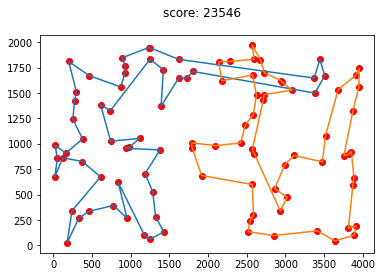

In [ ]:
draw_best(ver_data, lengths, greedyCycle, 'cycleB')

# LAB 2

## Tworzenie możliwych ruchów dla podanego wierzchołka

In [ ]:
def swap_vertex(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["vertex"]*(n), copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_vertex_cycle(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  return list(zip(["cycle"]*n, copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_edges(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["edges"]*(n), copy, [vertex]*(n),  [i]*(n)))

## Obliczanie delty funkcji celu

In [ ]:
def calculate_delta(typ, distance_matrix, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig1+2], list1[min1]]+ distance_matrix[
                                                          list1[neig2], list1[max1]] + distance_matrix[list1[neig2-2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig1+2], list1[max1]]+ distance_matrix[
                                                          list1[neig2], list1[min1]] + distance_matrix[list1[neig2-2], list1[min1]]
    if abs(ind1-ind2)==1 or neig2==min1:
      delta2+=2*distance_matrix[list1[ind1], list1[ind2]]


  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    if neig2==0 and min1==0:
      return 0
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig2], list1[min1]]

  elif typ=="cycle":
    if list_of_vertex2:
      list2 = list_of_vertex2[:-1]
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    indout1 = (ind1+1)%len(list1)
    indout2 = (ind2+1)%len(list2)
    delta1 = distance_matrix[list1[ind1-1], list1[ind1]] + distance_matrix[list1[indout1], list1[ind1]]+ distance_matrix[
                                                          list2[ind2-1], list2[ind2]] + distance_matrix[list2[indout2], list2[ind2]]
    delta2 = distance_matrix[list1[ind1-1], list2[ind2]] + distance_matrix[list1[indout1], list2[ind2]]+ distance_matrix[
                                                          list2[ind2-1], list1[ind1]] + distance_matrix[list2[indout2], list1[ind1]]
  return delta2-delta1

## Wykonywanie ruchu

In [ ]:
def move(typ, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  list2 = list_of_vertex2[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    list1[ind1], list1[ind2] = list1[ind2], list1[ind1] 

  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1, ind2)
    list1[min1:max1+1] = reversed(list1[min1:max1+1])

  else:
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    list1[ind1], list2[ind2] = list2[ind2], list1[ind1]
    

  list1.append(list1[0])
  list2.append(list2[0])
  return list1, list2


## Algorytmy wykorzystane do rozwiązania zadania

In [ ]:
def steepest(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      delta = 0
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)

      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < delta:
          best_move = m
          delta = new_delta

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), delta)
          print()
      else:
        break
      

  return start_solution


In [ ]:
def greedy(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < 0:
          best_move = m
          break

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), new_delta)
          print()
      else:
        break
      

  return start_solution

In [ ]:
def random_wandering(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  j = 0
  while j<100:
      j+=1
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      m = moves[random.randint(0, len(moves)-1)]
      i = m[3]
      new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
      if new_delta < 0:
        best_move = m

      if best_move:
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution))
          print()
      
      

  return start_solution

time: 27.8 ms (started: 2022-04-03 12:43:20 +00:00)


## Uruchamianie eksperymentów

In [ ]:
def test_lab2(n, heuris, ver_data, algor = steepest, swap = swap_vertex):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  best_length = np.inf
  best = None
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    vertexes = algor(distance_matrix, swap, start_solution = vertexes, verbose = False)
    length = calculateCycleLength(distance_matrix, vertexes)
    if length < best_length:
      best = vertexes
      best_length = length
    lengths.append(length)
  return lengths, best, best_length

In [ ]:
def draw_best2(ver_data, best, length, filename = "cos"):
  for graph in best:
    x = ver_data[graph, 0]
    y = ver_data[graph,1]
    plt.plot(x, y)
  plt.scatter(ver_data[:, 0], ver_data[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')

In [ ]:
#load time measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

time: 6.98 ms (started: 2022-04-03 13:33:01 +00:00)


In [ ]:
# algor to choose: steepest, greedy or random_wandering, swap: swap_edges or swap_vertex
lengt, best, bl = test_lab2(100, two_regret, ver_data, algor = steepest, swap = swap_edges)

time: 3min 10s (started: 2022-04-03 13:33:03 +00:00)


In [ ]:
print(f'{round(sum(lengt)/len(lengt))} ({min(lengt)}-{max(lengt)})')

24179 (22534-27517)
time: 2.58 ms (started: 2022-04-03 13:49:30 +00:00)


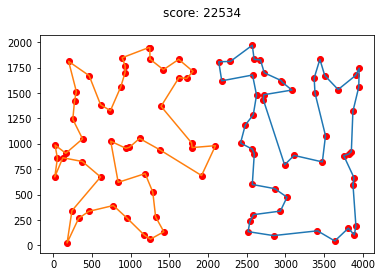

time: 703 ms (started: 2022-04-03 13:49:39 +00:00)


In [ ]:
draw_best2(ver_data, best, bl, filename="steepest")

# LAB 3

In [ ]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint
import time

In [ ]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA200.tsp')
kroBProblem = tsplib95.load('kroB200.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

In [ ]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [ ]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [ ]:
def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def random_heuristic(matrix, start):
    import random
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

## Ruchy kandydackie

In [ ]:
def find_cycle(cycles, a):
    if a in cycles[0]:
      return 0, cycles[0].index(a)
    return 1, cycles[1].index(a)

def reverse(cycle, i, j):
    n = len(cycle)
    d = (j - i) % n
    for k in range(d//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        cycle[a], cycle[b] = cycle[b], cycle[a]

def calculate_delta(typ, matrix, a, b, cycle1, cycle2, i, j):
    if typ == "edges":
      n = len(cycle1)
      a, b, c, d = a, cycle1[(i+1)%n], b, cycle1[(j+1)%n]
      return matrix[a, c] + matrix[b, d] - matrix[a, b] - matrix[c, d]
    elif typ=="cycles":
      n, m = len(cycle1), len(cycle2)
      x1, y1, z1 = cycle1[(i-1)%n], cycle1[i], cycle1[(i+1)%n]
      x2, y2, z2 = cycle2[(j-1)%m], cycle2[j], cycle2[(j+1)%m]
      return matrix[x1,y2] + matrix[z1,y2] - matrix[x1,y1] - matrix[z1,y1] + matrix[x2,y1] + matrix[z2,y1] - matrix[x2,y2] - matrix[z2,y2]


def move(typ, a, b, cycles):
    if typ == "edges":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif typ == "cycles":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]


In [ ]:
def steepest_candidate_movements(matrix, visited_1, visited_2, k=10):
    N = len(matrix)
    cycles = [visited_1, visited_2]

    while True:
        best_move, best_delta = None, 0
        for a in range(N):
            for b in np.argpartition(matrix[a], k+1)[:k+1]:
                if a == b:
                  continue

                c1, i = find_cycle(cycles, a)
                c2, j = find_cycle(cycles, b)
                M, delta = None, None
                if c1 == c2:
                    delta = calculate_delta("edges", matrix, a, b, cycles[c1], None, i, j)
                    M = a, b, "edges"
                else:
                    delta = calculate_delta("cycles", matrix, a, b, cycles[c1], cycles[c2], i, j)
                    M = a, b, "cycles"
                if delta < best_delta:
                    best_delta, best_move = delta, M
                    
        if best_move is None:
            break
        a, b, typ = best_move
        move(typ, a, b, cycles)
            
    return cycles[0], cycles[1]

## Lokalne przeszukiwania z listą ruchów przynoszących poprawę


In [ ]:
def is_edge(cycle, a, b):
  if a in cycle and b in cycle:
    return cycle.index(b) - cycle.index(a) if abs(cycle.index(b) - cycle.index(a))==1 else 0
  return False

def start_moves(matrix, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i in range(n):
            for j in range(i+1, n):
              delta = calculate_delta("edges",matrix, cycle[i], cycle[j], cycle, None, i, j)
              if delta<0:
                moves.append([delta, cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n], "edges"])

    for i in range(len(cycles[0])):
      for j in range(len(cycles[1])):
        delta = calculate_delta("cycles",matrix, cycles[0][i], cycles[1][j], cycles[0], cycles[1], i, j)
        if delta<0:
          n, m = len(cycles[0]), len(cycles[1])
          x1, y1, z1 = cycles[0][(i-1)%n], cycles[0][i], cycles[0][(i+1)%n]
          x2, y2, z2 = cycles[1][(j-1)%m], cycles[1][j], cycles[1][(j+1)%m]
          moves.append([delta, 0, 1, x1, y1, z1, x2, y2, z2, "cycles"])
    return moves
 



def next_moves(matrix, cycles, typ, a, b):
    moves = []
    if typ == "edges":
        cycle = cycles[0] if a in cycles[0] else cycles[1]
        n = len(cycle)
        I = cycle.index(a)
        for i in range(I, n):
          for j in range(i+1, n):
            delta = calculate_delta("edges",matrix, cycle[i], cycle[j], cycle, None, i, j)
            if delta<0:
              moves.append([delta, cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n], "edges"])
            delta = calculate_delta("edges",matrix, cycle[j], cycle[i], cycle, None, j, i)
            if delta<0:
              moves.append([delta, cycle[j], cycle[(j+1)%n], cycle[i], cycle[(i+1)%n], "edges"])

    elif typ == "cycles":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        n, m = len(cycles[c1]), len(cycles[c2])
        for k in range(m):
            delta = calculate_delta("cycles",matrix, a, cycles[c2][k], cycles[c1], cycles[c2], i, k)
            if delta<0:
              x1, y1, z1 = cycles[c1][(i-1)%n], cycles[c1][i], cycles[c1][(i+1)%n]
              x2, y2, z2 = cycles[c2][(k-1)%m], cycles[c2][k], cycles[c2][(k+1)%m]
              moves.append([delta, c1, c2, x1, y1, z1, x2, y2, z2, "cycles"])
        for k in range(n):
            delta = calculate_delta("cycles",matrix, b, cycles[c1][k], cycles[c2], cycles[c1], j, k)
            if delta<0:
              x1, y1, z1 = cycles[c2][(j-1)%n], cycles[c2][j], cycles[c2][(j+1)%n]
              x2, y2, z2 = cycles[c1][(k-1)%m], cycles[c1][k], cycles[c1][(k+1)%m]
              moves.append([delta, c2, c1, x1, y1, z1, x2, y2, z2, "cycles"])
    return moves

time: 83.1 ms (started: 2022-05-11 12:46:53 +00:00)


In [ ]:
def steepest_list_better_moves(matrix, cycles):
    moves = sorted(start_moves(matrix, cycles), key=lambda x: x[0])

    while True:
        to_remove = []
        best_move = None
        for k, M in enumerate(moves):

            if M[-1] == "edges":
                _, a, b, c, d, _ = M

                c1, s1, c2, s2 = None, False, None, False

                for i in range(2):
                  status = is_edge(cycles[i], a, b)
                  if status: 
                    c1, s1 = i, status
                
                
                for i in range(2):
                  status = is_edge(cycles[i], c, d)
                  if status: 
                    c2, s2 = i, status

                if c1 != c2 or False in [s1,s2]:
                    to_remove.append(k)
                elif s1 == s2 == 1:
                    to_remove.append(k)
                    best_move = a, c, "edges"
                    break
                elif s1 == s2 == -1:
                    to_remove.append(k)
                    best_move = b, d, "edges"
                    break


            elif M[-1] == "cycles":
                _, c1, c2, a, b, c, d, e, f, _ = M
                S = [[c1, a, b], [c1, b, c], [c2, d, e], [c2, e, f]]
                s = []
                for s in S:
                  s.append(is_edge(cycles[s[0]], s[1], s[2]))
                
                if c1 == c2 or False in s:
                    to_remove.append(k)
                elif s[0] == s[1] and s[2] == s[3]:
                    to_remove.append(k)
                    best_move = b, e, "cycles"
                    break
                
        if best_move is None:
            break
            
        for i in reversed(to_remove):
          del(moves[i])

        a, b, typ = best_move

        move(typ, a, b, cycles)
        new_moves = next_moves(matrix, cycles, typ, a, b)
       
        moves.extend(new_moves)
        moves = sorted(moves, key=lambda x: x[0])
  
        
    return cycles

time: 79 ms (started: 2022-05-11 12:22:22 +00:00)


## Testowanie algorytmów

In [ ]:
#load time measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
version = verticesA
matrix = distance_matrix(version)
best_sum = np.inf
best = None
sums = []

for i in range(100):
  start_node_1 = i
  visited_1, visited_2 = random_heuristic(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_list_better_moves(matrix, [visited_1, visited_2])
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum

print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(version, best, min(sums), "lepszeRuchyA")



In [ ]:
version = verticesB
matrix = distance_matrix(version)
best_sum = np.inf
best = None
sums = []
for i in range(100):
  start_node_1 = i
  visited_1, visited_2 = random_heuristic(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_candidate_movements(matrix, visited_1, visited_2)
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum
    


print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(version, best, min(sums), "kandydackiB")


# LAB 4

## MSLS

In [ ]:
from random import randint
def multiple_start_local_search(matrix, numIteration = 100):
  i = 0
  global_sum = np.inf
  final_visited_1, final_visited_2 = [], []
  
  # stop condition => 100 iterations
  pbar = tqdm(total=numIteration)
  while i < numIteration:
    pbar.update(1)
    # generate random start solution
    start_vertice = randint(0, len(matrix) - 1)
    [visited_1, visited_2] = random_heuristic(matrix, start_vertice)

    # Local search 
    # steepest_change_vertices(matrix, visited_1, visited_2)
    visited_1, visited_2 = greedy(matrix, start_solution = [visited_1, visited_2], verbose = False)
    sum = calculateCycleLength(matrix, [visited_1, visited_2])

    # check if it's better than last
    if (sum < global_sum):
      global_sum = sum
      final_visited_1, final_visited_2 = visited_1, visited_2

    i += 1
  pbar.close()

  return final_visited_1, final_visited_2

time: 588 µs (started: 2022-05-15 22:07:13 +02:00)


## ILS

In [ ]:
def change_solution(visited_1, visited_2):
  first = randint(0, len(visited_1) - 1)
  second = randint(0, len(visited_2) - 1)

  visited_1[first], visited_2[second] = visited_2[second], visited_1[first]

  return visited_1, visited_2

In [ ]:
def check_for_best_move(matrix, item, visited):
  min_value = np.inf
  min_index = None

  for i, vertex in enumerate(visited[0:-1]):
    temp_sum = matrix[vertex][item] + matrix[visited[i + 1]][item]

    if temp_sum < min_value:
      min_value = temp_sum
      min_index = i + 1

  return min_index

In [ ]:
def rebuilt_solution(matrix, visited_1, visited_2, deleted_vertices):

  if visited_1[0] != visited_1[-1]:
    visited_1 = np.append(visited_1, visited_1[0])

  if visited_2[0] != visited_2[-1]:
    visited_2 = np.append(visited_2, visited_2[0])

  for elem in deleted_vertices:
    if len(visited_2) < len(visited_1):
      visited_2 = np.insert(visited_2, check_for_best_move(matrix, elem, visited_2), elem)
    else:
      visited_1 = np.insert(visited_1, check_for_best_move(matrix, elem, visited_1), elem)
  
  return visited_1, visited_2

## ILS1

In [ ]:
def iterated_start_local_search_1(matrix, iterationNumChange=5, avgTime=919.5): # 9.5): # 
  
  start_vertice = randint(0, len(matrix) - 1)
  [visited_1, visited_2] = random_heuristic(matrix, start_vertice)
  steepest(matrix, start_solution=[visited_1, visited_2], verbose=False)
  global_sum = calculateCycleLength(matrix, [visited_1, visited_2])


  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)

    # simple perturabtion
    for i in range(0, iterationNumChange):
      temp_visited_1, temp_visited_2 = change_solution(temp_visited_1, temp_visited_2)

    # Local Search
    temp_visited_1, temp_visited_2 = greedy(matrix, start_solution=[temp_visited_1, temp_visited_2], verbose=False)
    #steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    
    sum = calculateCycleLength(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
  return visited_1, visited_2

## ILS 2

In [ ]:
def iterated_start_local_search_2(matrix, rebuildSize = 0.2, avgTime = 919.5):
  if rebuildSize > 1.0:
    print('Error rebuilt size must be <= 1.')
    rebuildSize = 0.2
 
  start_vertice = randint(0, len(matrix) - 1)
  visited_1, visited_2 = random_heuristic(matrix, start_vertice)
  # steepest_change_vertices(matrix, visited_1, visited_2)
  global_sum = calculateCycleLength(matrix, [visited_1, visited_2])

  start = time()
  end = 0

  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)
    deleted_vertices = []

    # destroy solution - perturbacja
    while len(temp_visited_1) + len(temp_visited_2) >= (1 - rebuildSize) * len(matrix):
      if len(temp_visited_1) > len(temp_visited_2): 
        delete_vertice = randint(0, len(temp_visited_1) - 1)
        deleted_vertices.append(temp_visited_1[delete_vertice])
        temp_visited_1 = np.delete(temp_visited_1, delete_vertice)

      else:
        delete_vertice = randint(0, len(temp_visited_2) - 1)
        deleted_vertices.append(temp_visited_2[delete_vertice])
        temp_visited_2 = np.delete(temp_visited_2, delete_vertice)

    # repair solution
    temp_visited_1, temp_visited_2 = rebuilt_solution(matrix, temp_visited_1, temp_visited_2, deleted_vertices)

    # Local Search
    # steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    temp_visited_1, temp_visited_2 = greedy(matrix, start_solution=[temp_visited_1, temp_visited_2], verbose=False)
    
    sum = calculateCycleLength(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
    end = time()
    
  return visited_1, visited_2

# LAB 4 (poprawione) i LAB 5

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import time
from tqdm import tqdm


def read_instance(filename):
    coordinates = []
    with open(filename) as mf:
        for _ in range(6):
            mf.readline()
        for line in mf:
            if line != 'EOF\n':
                coordinates.append([int(v) for v in line.split()[1:]])
    instance = np.zeros((len(coordinates), len(coordinates)), dtype=np.int32)
    for i in range(len(coordinates)):
        for j in range(i, len(coordinates)):
            dist = euclidian_distance(coordinates[i], coordinates[j])
            instance[i][j] = dist
            instance[j][i] = dist
    return coordinates, instance


def euclidian_distance(a, b):
    return round(math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2))


def evaluate_solution(instance, cycles):
    if np.any(np.unique(cycles) != np.arange(0, instance.shape[0], 1)):
        # print(np.argmax(np.bincount(np.array(cycles).flatten())))
        # print(np.count_nonzero(np.array(cycles).flatten() == 64))
        print(np.unique(cycles))
        print(cycles[0][0], cycles[1][0])
        print("Wrong solution")
    distance = 0
    for cycle in cycles:
        for i in range(len(cycle)):
            distance += instance[cycle[i], cycle[(i + 1) % len(cycle)]]
    return distance

In [ ]:
def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def random_cycle(instance, *args):
    vertices = np.arange(0, instance.shape[0])
    for _ in range(instance.shape[0]):
        random.shuffle(vertices)

    a_cycle = vertices[(instance.shape[0] // 2):]
    b_cycle = vertices[:(instance.shape[0] // 2)]

    return a_cycle, b_cycle


def greedy_cycle(instance, starting_point_a, starting_point_b):
    a_cycle = [starting_point_a]
    b_cycle = [starting_point_b]

    available = np.ones((instance.shape[0],), dtype=bool)
    available[starting_point_a] = False
    available[starting_point_b] = False

    b_cycle_length = instance.shape[0] // 2
    a_cycle_length = instance.shape[0] - b_cycle_length

    for cycle, length in ((a_cycle, a_cycle_length), (b_cycle, b_cycle_length)):

        # Add nearest neighbor
        min_distance = np.min(instance[cycle[0]][available])
        possible_destinations = np.squeeze(np.argwhere(instance[cycle[0]] == min_distance), axis=-1)
        for possible_destination in possible_destinations:
            if available[possible_destination]:
                cycle.append(possible_destination)
                available[possible_destination] = False
                break

        for i in range(length - 2):

            best_source = cycle[0]
            best_destination = np.argwhere(available)[0, 0]
            best_value = instance[best_source, best_destination] + \
                         instance[cycle[1], best_destination] - \
                         instance[cycle[0], cycle[1]]

            for j in range(len(cycle)):
                for k in range(instance.shape[0]):
                    if available[k]:
                        value = instance[cycle[j], k] + \
                                instance[k, cycle[(j+1) % len(cycle)]] - \
                                instance[cycle[j], cycle[(j+1) % len(cycle)]]
                        if value < best_value:
                            best_source = cycle[j]
                            best_destination = k
                            best_value = value

            cycle.insert(cycle.index(best_source) + 1, best_destination)
            available[best_destination] = False

    return a_cycle, b_cycle


def greedy_cycle_repair(instance, starting_cycle_a, starting_cycle_b):
    a_cycle = starting_cycle_a
    b_cycle = starting_cycle_b

    available = np.ones((instance.shape[0],), dtype=bool)
    for a in a_cycle:
        available[a] = False
    for b in b_cycle:
        available[b] = False

    b_cycle_length = instance.shape[0] // 2
    a_cycle_length = instance.shape[0] - b_cycle_length

    for cycle, length in ((a_cycle, a_cycle_length), (b_cycle, b_cycle_length)):

        # Added
        if len(cycle) == length:
            continue

        # Add nearest neighbor
        min_distance = np.min(instance[cycle[0]][available])
        possible_destinations = np.squeeze(np.argwhere(instance[cycle[0]] == min_distance), axis=-1)
        for possible_destination in possible_destinations:
            if available[possible_destination]:
                cycle.append(possible_destination)
                available[possible_destination] = False
                break

        l = len(cycle)
        for i in range(length - l):

            best_source = cycle[0]
            best_destination = np.argwhere(available)[0, 0]
            best_value = instance[best_source, best_destination] + \
                         instance[cycle[1], best_destination] - \
                         instance[cycle[0], cycle[1]]

            for j in range(len(cycle)):
                for k in range(instance.shape[0]):
                    if available[k]:
                        value = instance[cycle[j], k] + \
                                instance[k, cycle[(j + 1) % len(cycle)]] - \
                                instance[cycle[j], cycle[(j + 1) % len(cycle)]]
                        if value < best_value:
                            best_source = cycle[j]
                            best_destination = k
                            best_value = value

            cycle.insert(cycle.index(best_source) + 1, best_destination)
            available[best_destination] = False

    return a_cycle, b_cycle


def steepest_local_search(a_cycle, b_cycle, distance_matrix, neighbor_type='1'):
    start_time = time.time()
    a_cycle_result = a_cycle.copy()
    b_cycle_result = b_cycle.copy()
    i = 0
    M = generate_moves(a_cycle_result, b_cycle_result, neighbor_type)
    while True:
        i = i + 1
        bestMove = (0, None)

        for move in M:
            delta = calculate_delta(a_cycle_result, b_cycle_result, distance_matrix, move)
            if delta < bestMove[0]:
                bestMove = (delta, move)

        if bestMove[1] is not None:
            a_cycle_result, b_cycle_result = apply_move(a_cycle_result, b_cycle_result, bestMove[1])
        else:
            break

    elapsed_time_seconds = time.time() - start_time
    return a_cycle_result, b_cycle_result, elapsed_time_seconds


def greedy_local_search(a_cycle, b_cycle, distance_matrix, neighbor_type='2'):
    start_time = time.time()
    a_cycle_result = a_cycle.copy()
    b_cycle_result = b_cycle.copy()
    i = 0
    M = generate_moves(a_cycle_result, b_cycle_result, neighbor_type)
    while True:
        # print(f"Greedy iteration: {i}")
        i = i + 1
        no_better_moves = True
        random_bias = random.randrange(0, len(M))
        random_direction = random.randrange(-1, 2, 2)

        for ind in range(len(M)):
            move = M[random_direction * ((ind + random_bias) % len(M))]
            delta = calculate_delta(a_cycle_result, b_cycle_result, distance_matrix, move)
            if delta < 0:
                # print(f"Aplying move {move} with delta={delta}")
                a_cycle_result, b_cycle_result = apply_move(a_cycle_result, b_cycle_result, move)
                no_better_moves = False
                break

        if no_better_moves:
            break

    elapsed_time_seconds = time.time() - start_time
    return a_cycle_result, b_cycle_result, elapsed_time_seconds

In [ ]:
def calculate_delta(a_cycle, b_cycle, distance_matrix, move):
    result = 0

    if move[0] == 0:
        ind_a, ind_b = move[1][0], move[1][1]

        vert_a, vert_b = a_cycle[ind_a], b_cycle[ind_b]
        vert_a_before, vert_b_before = a_cycle[ind_a - 1], b_cycle[ind_b - 1]
        vert_a_after, vert_b_after = a_cycle[(ind_a + 1) % len(a_cycle)], b_cycle[(ind_b + 1) % len(b_cycle)]

        result = distance_matrix[vert_a_before][vert_b] \
                 + distance_matrix[vert_b][vert_a_after] \
                 - distance_matrix[vert_a_before][vert_a] \
                 - distance_matrix[vert_a][vert_a_after] \
                 + distance_matrix[vert_b_before][vert_a] \
                 + distance_matrix[vert_a][vert_b_after] \
                 - distance_matrix[vert_b_before][vert_b] \
                 - distance_matrix[vert_b][vert_b_after]

    elif move[0] == 1:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind_1 = min(move[1][1], move[1][2])
        ind_2 = max(move[1][1], move[1][2])
        # przypadki brzegowe
        if ind_1 == 0 and ind_2 == len(cycle) - 1 or ind_1 == 0 and ind_2 == len(cycle) - 2:
            ind_1 = ind_2
            ind_2 = 0
        elif ind_1 == 1 and ind_2 == len(cycle) - 1:
            ind_1 = ind_2
            ind_2 = 1

        vert_1, vert_2 = cycle[ind_1], cycle[ind_2]
        vert_1_before, vert_2_before = cycle[ind_1 - 1], cycle[ind_2 - 1]

        if ind_1 + 1 >= len(cycle):
            vert_1_after = cycle[0]
        else:
            vert_1_after = cycle[ind_1 + 1]

        if ind_2 + 1 >= len(cycle):
            vert_2_after = cycle[0]
        else:
            vert_2_after = cycle[ind_2 + 1]

        if abs(ind_1 - ind_2) in [1, 2, 48, 49]:
            result = distance_matrix[vert_1_before][vert_2] \
                     - distance_matrix[vert_1_before][vert_1] \
                     + distance_matrix[vert_1][vert_2_after] \
                     - distance_matrix[vert_2][vert_2_after]

        else:
            result = distance_matrix[vert_1_before][vert_2] + \
                     distance_matrix[vert_2][vert_1_after] - \
                     distance_matrix[vert_1_before][vert_1] - \
                     distance_matrix[vert_1][vert_1_after] + \
                     distance_matrix[vert_2_before][vert_1] + \
                     distance_matrix[vert_1][vert_2_after] - \
                     distance_matrix[vert_2_before][vert_2] - \
                     distance_matrix[vert_2][vert_2_after]

    elif move[0] == 2:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind_1, ind_2, ind_3, ind_4 = move[1][1], move[1][2], move[1][3], move[1][4]
        vert_1, vert_2, vert_3, vert_4 = cycle[ind_1], cycle[ind_2], cycle[ind_3], cycle[ind_4]

        result = distance_matrix[vert_1][vert_3] + \
                 distance_matrix[vert_2][vert_4] - \
                 distance_matrix[vert_1][vert_2] - \
                 distance_matrix[vert_3][vert_4]

    else:
        raise Exception()

    return result


def apply_move(a_cycle, b_cycle, move):
    if move[0] == 0:
        temp = a_cycle[move[1][0]]
        a_cycle[move[1][0]] = b_cycle[move[1][1]]
        b_cycle[move[1][1]] = temp

    elif move[0] == 1:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        temp = cycle[move[1][1]]
        cycle[move[1][1]] = cycle[move[1][2]]
        cycle[move[1][2]] = temp


    elif move[0] == 2:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind1, ind2, ind3, ind4 = move[1][1:]

        c1 = cycle[:min(ind2, ind4)]
        c2 = cycle[max(ind2, ind4) - 1:min(ind2, ind4) - 1:-1]
        c3 = cycle[max(ind2, ind4):]

        cycle = list(c1) + list(c2) + list(c3)

        if move[1][0] == 0:
            a_cycle = cycle
        elif move[1][0] == 1:
            b_cycle = cycle

    return a_cycle, b_cycle


def generate_moves(a_cycle, b_cycle, neighbor_type):
    # Move is a tuple (x, M), where x = 0,1,2 depending on move type and M is move
    result_moves = []

    # ruchy międzytrasowe
    for a_index in range(len(a_cycle)):
        for b_index in range(len(b_cycle)):
            move = (0, (a_index, b_index))
            result_moves.append(move)

    # ruchy wewnątrztrasowe
    if neighbor_type == '1':
        # wymiana wierzchołków
        for cycle_no, cycle in enumerate([a_cycle, b_cycle]):
            for ind1 in range(len(cycle)):
                for ind2 in range(len(cycle)):
                    if ind1 == ind2:
                        continue
                    move = (1, (cycle_no, ind1, ind2))
                    result_moves.append(move)


    elif neighbor_type == '2':
        # wymiana krawędzi
        for cycle_no, cycle in enumerate([a_cycle, b_cycle]):
            for ind1 in range(len(cycle) - 1):
                for ind2 in range(len(cycle) - 1):
                    if abs(ind1 - ind2) < 2:
                        continue
                    if ind1 == len(cycle) - 1:
                        ind1b = 0
                    else:
                        ind1b = ind1 + 1
                    if ind2 == len(cycle) - 1:
                        ind2b = 0
                    else:
                        ind2b = ind2 + 1
                    move = (2, (cycle_no, ind1, ind1b, ind2, ind2b))
                    result_moves.append(move)

    else:
        raise Exception()

    return result_moves

In [ ]:
def multiple_start_local_search(dist_matrix, iterations=100, start='random'):
    start_time = time.time()

    a_best, b_best = None, None
    best_result = np.inf
    for i in range(iterations):
        if start == 'random':
            a, b = random_cycle(dist_matrix)
        else:
            start_verts = random.sample(range(dist_matrix.shape[0]), 2)
            a, b = greedy_cycle(dist_matrix, start_verts[0], start_verts[1])

        a_res, b_res, _ = greedy_local_search(a, b, dist_matrix, '2')
        result = evaluate_solution(dist_matrix, (a_res, b_res))
        if result < best_result:
            a_best, b_best = a_res, b_res
            best_result = result

    elapsed_time_seconds = time.time() - start_time
    return a_best, b_best, elapsed_time_seconds

In [ ]:
def perturbation1(a_cycle, b_cycle, moves_count=5):
    M = generate_moves(a_cycle, b_cycle, '2')
    moves = random.sample(M, moves_count)
    for move in moves:
        a_cycle, b_cycle = apply_move(a_cycle, b_cycle, move)

    return a_cycle, b_cycle


def iterated_local_search_1(dist_matrix, duration_time_seconds, start='random'):
    start_time = time.time()
    if start == 'random':
        a, b = random_cycle(dist_matrix)
    else:
        start_verts = random.sample(range(dist_matrix.shape[0]), 2)
        a, b = greedy_cycle(dist_matrix, start_verts[0], start_verts[1])

    a_res, b_res, _ = greedy_local_search(a, b, dist_matrix, '2')
    a_best, b_best, best_result = a_res, b_res, evaluate_solution(dist_matrix, (a_res, b_res))

    while time.time() - start_time < duration_time_seconds:
        a, b = perturbation1(a_res.copy(), b_res.copy())
        a_res, b_res, _ = greedy_local_search(a, b, dist_matrix, '2')
        result = evaluate_solution(dist_matrix, (a_res, b_res))
        if result < best_result:
            a_best, b_best = a_res, b_res
            best_result = result

    elapsed_time_seconds = time.time() - start_time
    return a_best, b_best, elapsed_time_seconds

In [ ]:
def perturbation2(dist_matrix, a_cycle, b_cycle, delete_percent=20):
    """ Destroy and repair """

    free_vertices = []
    for cycle in [a_cycle, b_cycle]:
        moves = int(len(cycle) * (delete_percent / 100))
        for i in range(moves):
            random_ind = random.randrange(len(cycle))
            free_vertices.append(cycle[random_ind])
            cycle.remove(cycle[random_ind])

    a_cycle, b_cycle = greedy_cycle_repair(dist_matrix, a_cycle, b_cycle)
    return a_cycle, b_cycle


def iterated_local_search_2a(dist_matrix, duration_time_seconds, start='random'):
    start_time = time.time()
    if start == 'random':
        a, b = random_cycle(dist_matrix)
    else:
        start_verts = random.sample(range(dist_matrix.shape[0]), 2)
        a, b = greedy_cycle(dist_matrix, start_verts[0], start_verts[1])

    a_res, b_res, _ = greedy_local_search(a, b, dist_matrix, '2')
    a_best, b_best, best_result = a_res, b_res, evaluate_solution(dist_matrix, (a_res, b_res))

    while time.time() - start_time < duration_time_seconds:
        a, b = perturbation2(dist_matrix, a_res.copy(), b_res.copy())
        a_res, b_res, _ = greedy_local_search(a, b, dist_matrix, '2')
        result = evaluate_solution(dist_matrix, (a_res, b_res))
        if result < best_result:
            a_best, b_best = a_res, b_res
            best_result = result

    elapsed_time_seconds = time.time() - start_time
    return a_best, b_best, elapsed_time_seconds

In [ ]:
def hybrid_evolutional(dist_matrix, duration_time_seconds=150, pop_size=20,
                       start_random=True, local_serach_after_recombination=True):

    start_time = time.time()

    # Wygeneruj populacje elitarna
    n = dist_matrix.shape[0]
    elit_pop = []
    scores = []
    while len(elit_pop) < pop_size:
        if start_random:
            a, b = random_cycle(dist_matrix)
            a = a.tolist()
            b = b.tolist()
        else:
            i, j = random.randrange(0, n), random.randrange(0, n)
            while i == j:
                i, j = random.randrange(0, n), random.randrange(0, n)
            a, b = greedy_cycle(dist_matrix, i, j)
            evaluate_solution(dist_matrix, (a, b))
        score = evaluate_solution(dist_matrix, (a, b))
        if score not in scores:
            elit_pop.append(((a, b), score))
    elit_pop.sort(key=lambda x: x[1])

    # print(elit_pop[-1][1])
    no_improvement_counter = 300

    while time.time() - start_time < duration_time_seconds and no_improvement_counter > 0:

        # select two random parents
        i, j = random.randrange(0, pop_size), random.randrange(0, pop_size)
        while i == j:
            i, j = random.randrange(0, pop_size), random.randrange(0, pop_size)
        parent1, parent2 = elit_pop[i], elit_pop[j]

        # recombine
        new_solution = [[], []]
        for cycle_num in range(2):
            cycle = parent1[0][cycle_num]
            for i in range(len(cycle)):
                edge_a, edge_b = cycle[i], cycle[(i + 1) % len(cycle)]
                for parent_cycle in parent2[0]:
                    if edge_a in parent_cycle:
                        ind = parent_cycle.index(edge_a)
                        if parent_cycle[(ind - 1) % len(parent_cycle)] == edge_b or \
                                parent_cycle[(ind + 1) % len(parent_cycle)] == edge_b:
                            for edge in (edge_a, edge_b):
                                if edge not in new_solution[cycle_num]:
                                    new_solution[cycle_num].append(edge)

        # if cycles empty -> initialize them
        for c, cycle in enumerate(new_solution):
            if len(cycle) == 0:
                cycle.append(parent1[0][c][0])

        # repair
        a, b = steepest_local_search(dist_matrix, new_solution[0], new_solution[1])

        # local search after recombination
        if local_serach_after_recombination:
            a, b, _ = greedy_local_search(a, b, dist_matrix)

        # check score and add to elite population if better and not same
        score = evaluate_solution(dist_matrix, (a, b))
        if score < elit_pop[-1][1]:
            for i in range(len(elit_pop)):
                if score < elit_pop[i][1]:
                    elit_pop.insert(i, ((a.copy(), b.copy()), score))
                    elit_pop.pop()
                    # print(elit_pop[-1][1])
                    no_improvement_counter = 301
                    break
                elif score == elit_pop[i][1]:
                    # print("Same score already in elit_pop!")
                    break
        no_improvement_counter -= 1


    total_time = time.time() - start_time

    return elit_pop[0], total_time

In [ ]:
besta = np.inf
bestb = np.inf
graph_dataa = None
graph_datab = None
timesa = []
timesb = []
sola = []
solb = []
# for i in range(1):
instances = ["kroA200.tsp", "kroB200.tsp"]
cooridantesA, instanceA = read_instance(instances[0])
cooridantesB, instanceB = read_instance(instances[1])
for _ in tqdm(range(1)):
    aa,ba,ta = multiple_start_local_search(instanceA)
    lengtha = evaluate_solution(instanceA, (aa,ba))
    timesa.append(ta)
    sola.append(lengtha)
    if lengtha < besta:
        besta = lengtha
        graph_dataa = (aa,ba)
    ab,bb,tb = multiple_start_local_search(instanceB)
    lengthb = evaluate_solution(instanceB, (ab,bb))
    timesb.append(tb)
    solb.append(lengthb)
    if lengthb < bestb:
        bestb = lengthb
        graph_datab = (ab,bb)



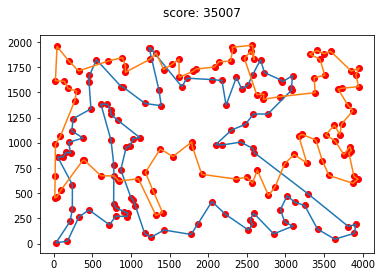

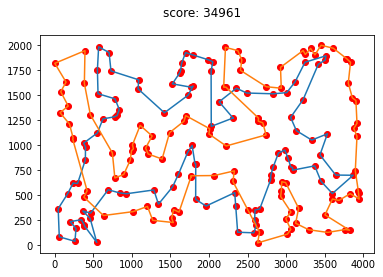

In [ ]:
graph_dataa[0].append(graph_dataa[0][0])
graph_datab[0].append(graph_datab[0][0])
graph_dataa[1].append(graph_dataa[1][0])
graph_datab[1].append(graph_datab[1][0])
draw_plot(cooridantesA, graph_dataa, besta, "MSLSA")
draw_plot(cooridantesB, graph_datab, bestb, "MSLSB")

In [ ]:
timesa = np.array(timesa)
timesb = np.array(timesb)
timesa = timesa - 200
timesb = timesb - 200

In [ ]:
print(f'{round(np.mean(timesa),2)} ({round(np.min(timesa),2)}-{round(np.max(timesa),2)})')
print(f'{round(np.mean(timesb),2)} ({round(np.min(timesb),2)}-{round(np.max(timesb),2)})')

print(f'{round(np.mean(sola),2)} ({round(np.min(sola),2)}-{round(np.max(sola),2)})')
print(f'{round(np.mean(solb),2)} ({round(np.min(solb),2)}-{round(np.max(solb),2)})')


150.39 (146.86-154.11)
155.08 (151.35-160.68)
35714.2 (35007-36515)
35363.4 (34961-35718)


In [ ]:
bestils1a = np.inf
bestils1b = np.inf
graph_datails1a = None
graph_datails1b = None
timesils1a = []
timesils1b = []
solils1a = []
solils1b = []
# for i in range(1):
instances = ["kroA200.tsp", "kroB200.tsp"]
cooridantesA, instanceA = read_instance(instances[0])
cooridantesB, instanceB = read_instance(instances[1])
for _ in tqdm(range(5)):
    aa,ba,ta = iterated_local_search_1(instanceA, round(np.mean(timesa),2))
    lengtha = evaluate_solution(instanceA, (aa,ba))
    timesils1a.append(ta)
    solils1a.append(lengtha)
    if lengtha < bestils1a:
        bestils1a = lengtha
        graph_datails1a = (aa,ba)
    ab,bb,tb = iterated_local_search_1(instanceB, round(np.mean(timesb),2))
    lengthb = evaluate_solution(instanceB, (ab,bb))
    timesils1b.append(tb)
    solils1b.append(lengthb)
    if lengthb < bestils1b:
        bestils1b = lengthb
        graph_datails1b = (ab,bb)

'''sol, t = hybrid_evolutional(instance, local_serach_after_recombination=True)
print("Score:", sol[1])
if sol[1]<best:
    best=sol[1]
    graph_data = sol[0]'''

100%|██████████| 5/5 [25:32<00:00, 306.52s/it]


'sol, t = hybrid_evolutional(instance, local_serach_after_recombination=True)\nprint("Score:", sol[1])\nif sol[1]<best:\n    best=sol[1]\n    graph_data = sol[0]'

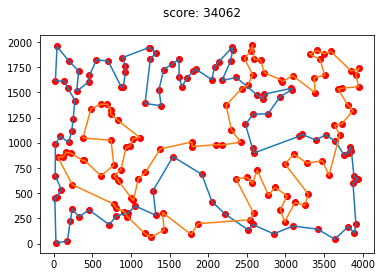

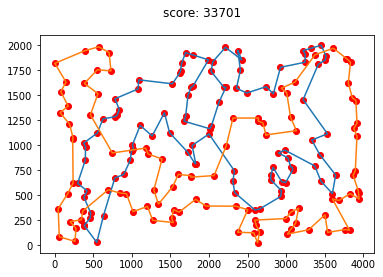

In [ ]:
graph_datails1a[0].append(graph_datails1a[0][0])
graph_datails1b[0].append(graph_datails1b[0][0])
graph_datails1a[1].append(graph_datails1a[1][0])
graph_datails1b[1].append(graph_datails1b[1][0])
draw_plot(cooridantesA, graph_datails1a, bestils1a, "ILS1A")
draw_plot(cooridantesB, graph_datails1b, bestils1b, "ILS1B")

In [ ]:
timesils1a = np.array(timesils1a)
timesils1b = np.array(timesils1b)

timesils1a = timesils1a + 200
timesils1b = timesils1b + 200

In [ ]:
print(f'{round(np.mean(timesils1a),2)} ({round(np.min(timesils1a),2)}-{round(np.max(timesils1a),2)})')
print(f'{round(np.mean(timesils1b),2)} ({round(np.min(timesils1b),2)}-{round(np.max(timesils1b),2)})')

print(f'{round(np.mean(solils1a),2)} ({round(np.min(solils1a),2)}-{round(np.max(solils1a),2)})')
print(f'{round(np.mean(solils1b),2)} ({round(np.min(solils1b),2)}-{round(np.max(solils1b),2)})')

350.95 (350.7-351.12)
355.57 (355.21-356.06)
34550.6 (34062-35121)
34192.2 (33701-34913)


In [ ]:
bestils1a = np.inf
bestils1b = np.inf
graph_datails1a = None
graph_datails1b = None
timesils1a = []
timesils1b = []
solils1a = []
solils1b = []
# for i in range(1):
instances = ["kroA200.tsp", "kroB200.tsp"]
cooridantesA, instanceA = read_instance(instances[0])
cooridantesB, instanceB = read_instance(instances[1])
for _ in tqdm(range(5)):
    aa,ba,ta = iterated_local_search_2a(instanceA, round(np.mean(timesa),2))
    lengtha = evaluate_solution(instanceA, (aa,ba))
    timesils1a.append(ta)
    solils1a.append(lengtha)
    if lengtha < bestils1a:
        bestils1a = lengtha
        graph_datails1a = (aa,ba)
    ab,bb,tb = iterated_local_search_2a(instanceB, round(np.mean(timesb),2))
    lengthb = evaluate_solution(instanceB, (ab,bb))
    timesils1b.append(tb)
    solils1b.append(lengthb)
    if lengthb < bestils1b:
        bestils1b = lengthb
        graph_datails1b = (ab,bb)

'''sol, t = hybrid_evolutional(instance, local_serach_after_recombination=True)
print("Score:", sol[1])
if sol[1]<best:
    best=sol[1]
    graph_data = sol[0]'''


In [ ]:
graph_datails1a[0].append(graph_datails1a[0][0])
graph_datails1b[0].append(graph_datails1b[0][0])
graph_datails1a[1].append(graph_datails1a[1][0])
graph_datails1b[1].append(graph_datails1b[1][0])
draw_plot(cooridantesA, graph_datails1a, bestils1a, "ILS2A")
draw_plot(cooridantesB, graph_datails1b, bestils1b, "ILS2B")

In [ ]:
timesils1a = np.array(timesils1a)
timesils1b = np.array(timesils1b)

timesils1a = timesils1a + 200
timesils1b = timesils1b + 200

In [ ]:
print(f'{round(np.mean(timesils1a),2)} ({round(np.min(timesils1a),2)}-{round(np.max(timesils1a),2)})')
print(f'{round(np.mean(timesils1b),2)} ({round(np.min(timesils1b),2)}-{round(np.max(timesils1b),2)})')

print(f'{round(np.mean(solils1a),2)} ({round(np.min(solils1a),2)}-{round(np.max(solils1a),2)})')
print(f'{round(np.mean(solils1b),2)} ({round(np.min(solils1b),2)}-{round(np.max(solils1b),2)})')

202.33 (202.12-202.92)
202.94 (201.74-204.0)
38872.4 (36970-40379)
39415.8 (38409-40367)


In [ ]:
bestha = np.inf
besthb = np.inf
graph_datailsha = None
graph_datailshb = None
timesha = []
timeshb = []
solha = []
solhb = []
instances = ["kroA200.tsp", "kroB200.tsp"]
cooridantesA, instanceA = read_instance(instances[0])
cooridantesB, instanceB = read_instance(instances[1])
for _ in tqdm(range(5)):
    sola, ta = hybrid_evolutional(instanceA, local_serach_after_recombination=True)
    solb, tb = hybrid_evolutional(instanceB, local_serach_after_recombination=True)
    sola[0][0].append(sola[0][0][0])
    solb[0][0].append(solb[0][0][0])
    sola[0][1].append(sola[0][1][0])
    solb[0][1].append(solb[0][1][0])
    lengtha = evaluate_solution(instanceA, sola[0])
    lengthb = evaluate_solution(instanceB, solb[0])
    solha.append(lengtha)
    solhb.append(lengthb)
    if sola[1]<bestha:
        bestha = sola[1]
        graph_datailsha = sola[0]
    if solb[1]<besthb:
        besthb = solb[1]
        graph_datailshb = solb[0]
    timesha.append(ta)
    timeshb.append(tb)
    



  0%|          | 0/5 [00:01<?, ?it/s]


TypeError: ignored

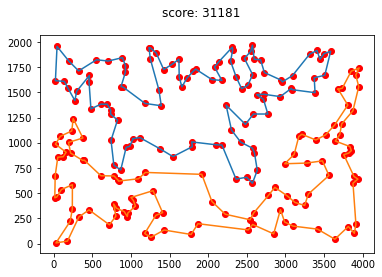

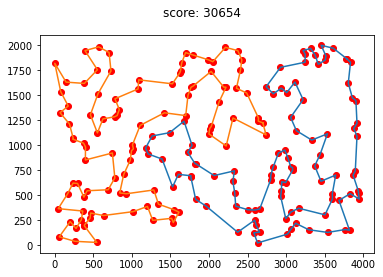

In [ ]:
draw_plot(cooridantesA, graph_datailsha, bestha, "HAEA")
draw_plot(cooridantesB, graph_datailshb, besthb, "HAEB")

In [ ]:
timesha = np.array(timesha)
timeshb = np.array(timeshb)

timesha = timesha + 200
timeshb = timeshb + 200

In [ ]:
print(f'{round(np.mean(timesha),2)} ({round(np.min(timesha),2)}-{round(np.max(timesha),2)})')
print(f'{round(np.mean(timeshb),2)} ({round(np.min(timeshb),2)}-{round(np.max(timeshb),2)})')

print(f'{round(np.mean(solha),2)} ({round(np.min(solha),2)}-{round(np.max(solha),2)})')
print(f'{round(np.mean(solhb),2)} ({round(np.min(solhb),2)}-{round(np.max(solhb),2)})')

350.75 (350.4-351.67)
355.18 (355.1-355.35)
31604.0 (31181-32160)
31522.6 (30654-32982)


# LAB 6

In [ ]:
def generate_greedy_solutions(name, n = 1000):
  cooridantes, instance= read_instance(name)
  solutions = []
  lengths = []
  for i in tqdm(range(n)):
    a, b = random_cycle(instance)
    a_res, b_res, _ = greedy_local_search(a, b, instance, '2')
    solutions.append([np.array(a_res), np.array(b_res)])
    lengths.append(evaluate_solution(instance, [a_res, b_res]))
  return solutions, lengths

In [ ]:
sol, lengths = generate_greedy_solutions("kroA200.tsp", n = 1000)

100%|██████████| 1000/1000 [42:21<00:00,  2.54s/it]


In [ ]:
def similarity_by_vertex(sol1, sol2):
  similarity = []
  for s1 in sol1:
    temp = []
    for s2 in sol2:
      n = 0
      for i in s1:
        if i in s2:
          n+=1
      temp.append(n)
    similarity.append(max(temp))
  return np.mean(similarity)/100

In [ ]:
def isSubArray(A, B):
  n = len(A)
  m = len(B)
  i = j = 0
  while (i < n and j < m):
    if (A[i] == B[j]):
      i += 1
      j += 1
      if (j == m):
        return True
    else:
      i = i - j + 1
      j = 0
    
  return False

def similarity_by_edge(sol1, sol2):
    similarity = []
    for s1 in sol1:
      n = 0
      for s2 in sol2:
        for i in range(s1.shape[0]):
          if isSubArray(s2, [s1[i], s1[(i+1)%s1.shape[0]]]) or isSubArray(s2, [s1[(i+1)%s1.shape[0]], s1[i]]):
            n+=1

      similarity.append(n)

    return np.mean(similarity)/99

In [ ]:
def similarity_best(sol, lengths, type_simil):
  from copy import deepcopy
  temp_sol = deepcopy(sol)
  temp_lengths = deepcopy(lengths)
  best = temp_sol.pop(np.argmin(temp_lengths))
  best_length = temp_lengths.pop(np.argmin(temp_lengths))
  similarity = []

  for i,s in enumerate(temp_sol):
      similarity.append(type_simil(best, s))
  return temp_lengths, similarity, best_length

In [ ]:
def mean_similarity(sol, lengths, type_simil, n = 50):
  index = np.argpartition(lengths, -n)[-n:]
  list_bool = np.bool_([True]*len(lengths))
  list_bool[index] = False
  from copy import deepcopy
  temp_sol = deepcopy(sol)

  all_similarity = []
  for i in index:
    best = temp_sol[i]
    similarity = []
    for i,s in enumerate(temp_sol):
        similarity.append(type_simil(best, s))
    all_similarity.append(similarity)

  all_similarity = np.array(all_similarity)[:, list_bool].mean(0)
  return all_similarity, np.array(lengths)[list_bool]

In [ ]:
def plot_similar(lengths, similarity,filename, title = "Best score", xlabel = "Funkcja celu", ylabel = "Podobieństwo"):
  plt.scatter(lengths, similarity)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(0, 1)
  plt.title(title)
  plt.savefig(filename)

In [ ]:
import pickle

with open("kroA.pickle", 'wb') as f:
  pickle.dump([sol, lengths], f)

In [ ]:
with open("kroA.pickle", 'rb') as f:
  soll, leenn = pickle.load(f)

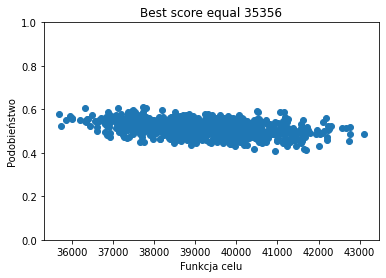

In [ ]:
l, s, bs = similarity_best(sol, lengths, similarity_by_edge)
plot_similar(l, s, filename = "kroA200edge.png", title = f"Best score equal {bs}")

In [ ]:
np.corrcoef(l, s)

array([[ 1.        , -0.54519972],
       [-0.54519972,  1.        ]])

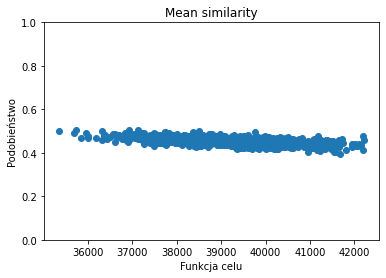

In [ ]:
s, l = mean_similarity(sol, lengths, similarity_by_edge, n = 10)
plot_similar(l, s, "kroA200edgemean.png", "Mean similarity")

# Lab 7

In [73]:
def read_instance(filename):
    coordinates = []
    with open(filename) as mf:
        for _ in range(6):
            mf.readline()
        for line in mf:
            if line != 'EOF\n':
                coordinates.append([int(v) for v in line.split()[1:]])
    instance = np.zeros((len(coordinates), len(coordinates)), dtype=np.int32)
    for i in range(len(coordinates)):
        for j in range(i, len(coordinates)):
            dist = euclidian_distance(coordinates[i], coordinates[j])
            instance[i][j] = dist
            instance[j][i] = dist
    return coordinates, instance


def euclidian_distance(a, b):
    return round(math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2))


def evaluate_solution(instance, cycles):
    if np.any(np.unique(cycles) != np.arange(0, instance.shape[0], 1)):
        # print(np.argmax(np.bincount(np.array(cycles).flatten())))
        # print(np.count_nonzero(np.array(cycles).flatten() == 64))
        print(np.unique(cycles))
        print(cycles[0][0], cycles[1][0])
        print("Wrong solution")
    distance = 0
    for cycle in cycles:
        for i in range(len(cycle)):
            distance += instance[cycle[i], cycle[(i + 1) % len(cycle)]]
    return distance


def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
#   plt.show()


def random_cycle(instance, *args):
    vertices = np.arange(0, instance.shape[0])
    for _ in range(instance.shape[0]):
        random.shuffle(vertices)

    a_cycle = vertices[(instance.shape[0] // 2):]
    b_cycle = vertices[:(instance.shape[0] // 2)]

    return a_cycle, b_cycle


def greedy_cycle(instance, starting_point_a, starting_point_b):
    a_cycle = [starting_point_a]
    b_cycle = [starting_point_b]

    available = np.ones((instance.shape[0],), dtype=bool)
    available[starting_point_a] = False
    available[starting_point_b] = False

    b_cycle_length = instance.shape[0] // 2
    a_cycle_length = instance.shape[0] - b_cycle_length

    for cycle, length in ((a_cycle, a_cycle_length), (b_cycle, b_cycle_length)):

        # Add nearest neighbor
        min_distance = np.min(instance[cycle[0]][available])
        possible_destinations = np.squeeze(np.argwhere(instance[cycle[0]] == min_distance), axis=-1)
        for possible_destination in possible_destinations:
            if available[possible_destination]:
                cycle.append(possible_destination)
                available[possible_destination] = False
                break

        for i in range(length - 2):

            best_source = cycle[0]
            best_destination = np.argwhere(available)[0, 0]
            best_value = instance[best_source, best_destination] + \
                         instance[cycle[1], best_destination] - \
                         instance[cycle[0], cycle[1]]

            for j in range(len(cycle)):
                for k in range(instance.shape[0]):
                    if available[k]:
                        value = instance[cycle[j], k] + \
                                instance[k, cycle[(j+1) % len(cycle)]] - \
                                instance[cycle[j], cycle[(j+1) % len(cycle)]]
                        if value < best_value:
                            best_source = cycle[j]
                            best_destination = k
                            best_value = value

            cycle.insert(cycle.index(best_source) + 1, best_destination)
            available[best_destination] = False

    return a_cycle, b_cycle

def perturbation(dist_matrix, a_cycle, b_cycle, delete_percent=30):
    """ Destroy and repair """

    free_vertices = []
    for cycle in [a_cycle, b_cycle]:
        moves = int(len(cycle) * (delete_percent / 100))
        for i in range(moves):
            random_ind = random.randrange(len(cycle))
            free_vertices.append(cycle[random_ind])
            cycle.remove(cycle[random_ind])

    a_cycle, b_cycle = greedy_cycle_repair2(dist_matrix, a_cycle, b_cycle)
    return a_cycle, b_cycle


def greedy_cycle_repair2(instance, starting_cycle_a, starting_cycle_b):
    a_cycle = starting_cycle_a
    b_cycle = starting_cycle_b

    available = np.ones((instance.shape[0],), dtype=bool)
    for a in a_cycle:
        available[a] = False
    for b in b_cycle:
        available[b] = False

    b_cycle_length = instance.shape[0] // 2
    a_cycle_length = instance.shape[0] - b_cycle_length

    for cycle, length in ((a_cycle, a_cycle_length), (b_cycle, b_cycle_length)):

        # Added
        if len(cycle) == length:
            continue

        # Add nearest neighbor
        ind = min(20, instance[cycle[0]][available].shape[0])
        values = np.argpartition(instance[cycle[0]][available], -ind)[-ind:]
        if ind>1:
          min_distance = values[np.random.randint(0, ind-1)]
        else:
          min_distance = values
        # min_distance = np.min(instance[cycle[0]][available])
        possible_destinations = np.squeeze(np.argwhere(instance[cycle[0]] == min_distance), axis=-1)
        for possible_destination in possible_destinations:
            if available[possible_destination]:
                cycle.append(possible_destination)
                available[possible_destination] = False
                break

        l = len(cycle)
        for i in range(length - l):

            best_source = cycle[0]
            best_destination = np.argwhere(available)[0, 0]
            best_value = instance[best_source, best_destination] + \
                         instance[cycle[1], best_destination] - \
                         instance[cycle[0], cycle[1]]

            for j in range(len(cycle)):
                for k in range(instance.shape[0]):
                    if available[k]:
                        value = instance[cycle[j], k] + \
                                instance[k, cycle[(j + 1) % len(cycle)]] - \
                                instance[cycle[j], cycle[(j + 1) % len(cycle)]]
                        if value < best_value:
                            best_source = cycle[j]
                            best_destination = k
                            best_value = value

            cycle.insert(cycle.index(best_source) + 1, best_destination)
            available[best_destination] = False

    return a_cycle, b_cycle



def greedy_local_search(a_cycle, b_cycle, distance_matrix, neighbor_type='2'):
    start_time = time.time()
    a_cycle_result = a_cycle.copy()
    b_cycle_result = b_cycle.copy()
    i = 0
    M = generate_moves(a_cycle_result, b_cycle_result, neighbor_type)
    while True:
        # print(f"Greedy iteration: {i}")
        i = i + 1
        no_better_moves = True
        random_bias = random.randrange(0, len(M))
        random_direction = random.randrange(-1, 2, 2)

        for ind in range(len(M)):
            move = M[random_direction * ((ind + random_bias) % len(M))]
            delta = calculate_delta(a_cycle_result, b_cycle_result, distance_matrix, move)
            if delta < 0:
                # print(f"Aplying move {move} with delta={delta}")
                a_cycle_result, b_cycle_result = apply_move(a_cycle_result, b_cycle_result, move)
                no_better_moves = False
                break

        if no_better_moves:
            break

    elapsed_time_seconds = time.time() - start_time
    return a_cycle_result, b_cycle_result, elapsed_time_seconds


def calculate_delta(a_cycle, b_cycle, distance_matrix, move):
    result = 0

    if move[0] == 0:
        ind_a, ind_b = move[1][0], move[1][1]

        vert_a, vert_b = a_cycle[ind_a], b_cycle[ind_b]
        vert_a_before, vert_b_before = a_cycle[ind_a - 1], b_cycle[ind_b - 1]
        vert_a_after, vert_b_after = a_cycle[(ind_a + 1) % len(a_cycle)], b_cycle[(ind_b + 1) % len(b_cycle)]

        result = +distance_matrix[vert_a_before][vert_b] \
                 + distance_matrix[vert_b][vert_a_after] \
                 - distance_matrix[vert_a_before][vert_a] \
                 - distance_matrix[vert_a][vert_a_after] \
                 + distance_matrix[vert_b_before][vert_a] \
                 + distance_matrix[vert_a][vert_b_after] \
                 - distance_matrix[vert_b_before][vert_b] \
                 - distance_matrix[vert_b][vert_b_after]

    elif move[0] == 1:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind_1 = min(move[1][1], move[1][2])
        ind_2 = max(move[1][1], move[1][2])
        # przypadki brzegowe
        if ind_1 == 0 and ind_2 == len(cycle) - 1 or ind_1 == 0 and ind_2 == len(cycle) - 2:
            ind_1 = ind_2
            ind_2 = 0
        elif ind_1 == 1 and ind_2 == len(cycle) - 1:
            ind_1 = ind_2
            ind_2 = 1

        vert_1, vert_2 = cycle[ind_1], cycle[ind_2]
        vert_1_before, vert_2_before = cycle[ind_1 - 1], cycle[ind_2 - 1]

        if ind_1 + 1 >= len(cycle):
            vert_1_after = cycle[0]
        else:
            vert_1_after = cycle[ind_1 + 1]

        if ind_2 + 1 >= len(cycle):
            vert_2_after = cycle[0]
        else:
            vert_2_after = cycle[ind_2 + 1]

        if abs(ind_1 - ind_2) in [1, 2, 48, 49]:
            result = +distance_matrix[vert_1_before][vert_2] \
                     - distance_matrix[vert_1_before][vert_1] \
                     + distance_matrix[vert_1][vert_2_after] \
                     - distance_matrix[vert_2][vert_2_after]

        else:
            result = distance_matrix[vert_1_before][vert_2] + \
                     distance_matrix[vert_2][vert_1_after] - \
                     distance_matrix[vert_1_before][vert_1] - \
                     distance_matrix[vert_1][vert_1_after] + \
                     distance_matrix[vert_2_before][vert_1] + \
                     distance_matrix[vert_1][vert_2_after] - \
                     distance_matrix[vert_2_before][vert_2] - \
                     distance_matrix[vert_2][vert_2_after]

    elif move[0] == 2:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind_1, ind_2, ind_3, ind_4 = move[1][1], move[1][2], move[1][3], move[1][4]
        vert_1, vert_2, vert_3, vert_4 = cycle[ind_1], cycle[ind_2], cycle[ind_3], cycle[ind_4]

        result = distance_matrix[vert_1][vert_3] + \
                 distance_matrix[vert_2][vert_4] - \
                 distance_matrix[vert_1][vert_2] - \
                 distance_matrix[vert_3][vert_4]

    else:
        raise Exception()

    return result


def apply_move(a_cycle, b_cycle, move):
    if move[0] == 0:
        temp = a_cycle[move[1][0]]
        a_cycle[move[1][0]] = b_cycle[move[1][1]]
        b_cycle[move[1][1]] = temp

    elif move[0] == 1:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        temp = cycle[move[1][1]]
        cycle[move[1][1]] = cycle[move[1][2]]
        cycle[move[1][2]] = temp


    elif move[0] == 2:
        if move[1][0] == 0:
            cycle = a_cycle
        elif move[1][0] == 1:
            cycle = b_cycle

        ind1, ind2, ind3, ind4 = move[1][1:]

        c1 = cycle[:min(ind2, ind4)]
        c2 = cycle[max(ind2, ind4) - 1:min(ind2, ind4) - 1:-1]
        c3 = cycle[max(ind2, ind4):]

        cycle = list(c1) + list(c2) + list(c3)

        if move[1][0] == 0:
            a_cycle = cycle
        elif move[1][0] == 1:
            b_cycle = cycle

    return a_cycle, b_cycle


def generate_moves(a_cycle, b_cycle, neighbor_type):
    # Move is a tuple (x, M), where x = 0,1,2 depending on move type and M is move
    result_moves = []

    # ruchy międzytrasowe
    for a_index in range(len(a_cycle)):
        for b_index in range(len(b_cycle)):
            move = (0, (a_index, b_index))
            result_moves.append(move)

    # ruchy wewnątrztrasowe
    if neighbor_type == '1':
        # wymiana wierzchołków
        for cycle_no, cycle in enumerate([a_cycle, b_cycle]):
            for ind1 in range(len(cycle)):
                for ind2 in range(len(cycle)):
                    if ind1 == ind2:
                        continue
                    move = (1, (cycle_no, ind1, ind2))
                    result_moves.append(move)


    elif neighbor_type == '2':
        # wymiana krawędzi
        for cycle_no, cycle in enumerate([a_cycle, b_cycle]):
            for ind1 in range(len(cycle) - 1):
                for ind2 in range(len(cycle) - 1):
                    if abs(ind1 - ind2) < 2:
                        continue
                    if ind1 == len(cycle) - 1:
                        ind1b = 0
                    else:
                        ind1b = ind1 + 1
                    if ind2 == len(cycle) - 1:
                        ind2b = 0
                    else:
                        ind2b = ind2 + 1
                    move = (2, (cycle_no, ind1, ind1b, ind2, ind2b))
                    result_moves.append(move)

    else:
        raise Exception()

    return result_moves

def hybrid_evolutional(dist_matrix, duration_time_seconds=20, pop_size=20,
                       start_random=False, local_serach_after_recombination=True,limit = 35000):

    # Wygeneruj populacje elitarna
    n = dist_matrix.shape[0]
    elit_pop = []
    scores = []
    while len(elit_pop) < pop_size:
        if start_random:
            a, b = random_cycle(dist_matrix)
            a = a.tolist()
            b = b.tolist()
        else:
            i, j = random.randrange(0, n), random.randrange(0, n)
            while i == j:
                i, j = random.randrange(0, n), random.randrange(0, n)
            # a, b, _ = iterated_local_search_2b(dist_matrix, 10)
            a, b = greedy_cycle(dist_matrix, i , j)
            # a, b = perturbation(dist_matrix, a, b, 30)
            a, b = perturbation(dist_matrix, a, b, random.randint(10, 40))
            a, b, _ = greedy_local_search(a, b, dist_matrix)
        score = evaluate_solution(dist_matrix, (a, b))
        if score not in scores and score<limit:
            elit_pop.append(((a, b), score))
            scores.append(score)
    elit_pop.sort(key=lambda x: x[1])
    print("Populacja gotowa")
    # print(elit_pop[-1][1])
    no_improvement_counter = 300
    start_time = time.time()
    while time.time() - start_time < duration_time_seconds and no_improvement_counter > 0:

        # select two random parents
        i, j = random.randrange(0, pop_size), random.randrange(0, pop_size)
        while i == j:
            i, j = random.randrange(0, pop_size), random.randrange(0, pop_size)
        parent1, parent2 = elit_pop[i], elit_pop[j]

        # recombine
        new_solution = [[], []]
        for cycle_num in range(2):
            cycle = parent1[0][cycle_num]
            for i in range(len(cycle)):
                edge_a, edge_b = cycle[i], cycle[(i + 1) % len(cycle)]
                for parent_cycle in parent2[0]:
                    if edge_a in parent_cycle:
                        ind = parent_cycle.index(edge_a)
                        if parent_cycle[(ind - 1) % len(parent_cycle)] == edge_b or \
                                parent_cycle[(ind + 1) % len(parent_cycle)] == edge_b:
                            for edge in (edge_a, edge_b):
                                if edge not in new_solution[cycle_num]:
                                    new_solution[cycle_num].append(edge)

        # if cycles empty -> initialize them
        for c, cycle in enumerate(new_solution):
            if len(cycle) == 0:
                cycle.append(parent1[0][c][0])

        # repair
        a, b = greedy_cycle_repair2(dist_matrix, new_solution[0], new_solution[1])

        # local search after recombination
        if local_serach_after_recombination:
            a, b = perturbation(dist_matrix, a, b)
            a, b, _ = greedy_local_search(a, b, dist_matrix)

        # check score and add to elite population if better and not same
        score = evaluate_solution(dist_matrix, (a, b))
        if score < np.array(elit_pop, dtype = 'object')[:, 1].min():
            # print(score)
            for i in range(len(elit_pop)):
                if score < elit_pop[i][1]:
                    elit_pop.insert(i, ((a.copy(), b.copy()), score))
                    elit_pop.pop()
                    # print(elit_pop[-1][1])
                    no_improvement_counter = 301
                    break
                elif score == elit_pop[i][1]:
                    # print("Same score already in elit_pop!")
                    break
        no_improvement_counter -= 1



    total_time = time.time() - start_time
    a_best, b_best = elit_pop[0][0][0], elit_pop[0][0][1]
    best_result = evaluate_solution(instance, (a_best, b_best))
    start_time = time.time()
    while time.time() - start_time < 80:
        a, b = perturbation(instance, a_best.copy(), b_best.copy(), random.randint(15, 45))
        a, b, _ = greedy_local_search(a, b, instance, '2')
        result = evaluate_solution(instance, (a, b))
        if result < best_result:
            # print(best_result)
            a_best, b_best = a, b
            best_result = result
    return [[a_best, b_best], best_result], total_time





In [75]:
import numpy as np
import math
import random
import time 
from tqdm import tqdm 

solutions = []
times = []
instances = ["kroA200.tsp"]
cooridantes, instance = read_instance(instances[0])
for _ in tqdm(range(10)):
  sol, t = hybrid_evolutional(instance, local_serach_after_recombination=True, duration_time_seconds = 200, pop_size = 5, limit = 33000)
  print("Score:", sol[1])
  solutions.append(sol)
  times.append(t)

  0%|          | 0/10 [00:00<?, ?it/s]

Populacja gotowa


 10%|█         | 1/10 [05:42<51:22, 342.48s/it]

Score: 30488
Populacja gotowa


 20%|██        | 2/10 [11:40<46:53, 351.68s/it]

Score: 30436
Populacja gotowa


 30%|███       | 3/10 [17:29<40:51, 350.23s/it]

Score: 30523
Populacja gotowa


 40%|████      | 4/10 [23:07<34:34, 345.70s/it]

Score: 30787
Populacja gotowa


 50%|█████     | 5/10 [29:12<29:22, 352.45s/it]

Score: 30365
Populacja gotowa


 60%|██████    | 6/10 [34:52<23:13, 348.29s/it]

Score: 30515
Populacja gotowa


 70%|███████   | 7/10 [40:21<17:06, 342.07s/it]

Score: 30378
Populacja gotowa


 80%|████████  | 8/10 [45:45<11:12, 336.27s/it]

Score: 31095
Populacja gotowa


 90%|█████████ | 9/10 [52:03<05:49, 349.41s/it]

Score: 30076
Populacja gotowa


100%|██████████| 10/10 [57:38<00:00, 345.85s/it]

Score: 30389


In [67]:
def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

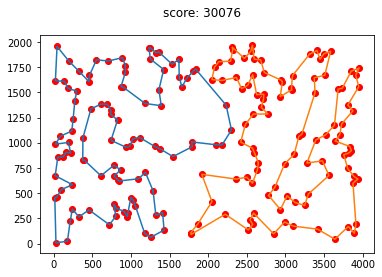

In [90]:
import matplotlib.pyplot as plt
from copy import deepcopy

best = deepcopy(solutions[-2])
best[0][0].append(best[0][0][0])
best[0][1].append(best[0][1][0])
draw_plot(cooridantes, best[0], solutions[-2][1], "bestkroA200")